<a href="https://colab.research.google.com/github/Shrondi/smart-bridges/blob/main/visualizer_smartbridges.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importación e instalación

In [ ]:
!pip install -q pandas
!pip install -q matplotlib
!pip install -q plotly

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

# Definición funciones

In [107]:
def plot_train(input_path):
    """
    Loads data from CSV files (directory or single file) and plots them on the same graph.
    """

    def plot_accelerometer_data(df):
        # Crear una figura y tres ejes FUERA del bucle
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 18))

        # Obtener el primer datetime para usarlo como titulo
        first_datetime = df.index[0]

        formatted_date = first_datetime.strftime("%d/%m")  # Dia/Mes
        formatted_time = first_datetime.strftime("%H:%M:%S")  # Hora:Minutos:Segundos

        # Crear titulo de la figura
        figure_title = f"Tren {formatted_date} {formatted_time}"
        fig.suptitle(figure_title, fontsize=16, fontweight='bold')

        fig.subplots_adjust(hspace=0.3, top=0.92)

        # Paleta de colores para los acelerometros
        palette = sns.color_palette('bright', n_colors=8)

        # Create a color map using the palette
        colors = {
            1: {'x': palette[0], 'y': palette[1], 'z': palette[2]},
            2: {'x': palette[3], 'y': palette[4], 'z': palette[5]},
            3: {'x': palette[6], 'y': palette[7], 'z': palette[0]},
            4: {'x': palette[1], 'y': palette[2], 'z': palette[3]},
            5: {'x': palette[4], 'y': palette[5], 'z': palette[6]},
            6: {'x': palette[7], 'y': palette[0], 'z': palette[1]},
            7: {'x': palette[2], 'y': palette[3], 'z': palette[4]},
            8: {'x': palette[5], 'y': palette[6], 'z': palette[7]}
        }

        # Plotear datos
        for acc_num in df['accelerometer'].unique():
            df_acc = df[df['accelerometer'] == acc_num]
            df_acc = df_acc[['x', 'y', 'z']]

            # Calculate time difference in seconds
            time_diff = (df_acc.index - df_acc.index[0]).to_series().dt.total_seconds()

            # Access color using accelerometer number and axis
            ax1.plot(time_diff, df_acc['x'], label=f'Acc {acc_num} (x)', color=colors.get(acc_num, {}).get('x'))
            ax2.plot(time_diff, df_acc['y'], label=f'Acc {acc_num} (y)', color=colors.get(acc_num, {}).get('y'))
            ax3.plot(time_diff, df_acc['z'], label=f'Acc {acc_num} (z)', color=colors.get(acc_num, {}).get('z'))

        # Configurar ejes para cada gráfica
        for ax in [ax1, ax2, ax3]:
            ax.set_xlabel('Tiempo [s]', fontsize=12)
            ax.set_ylabel('Aceleración [g]', fontsize=12)
            ax.legend(loc="lower left")
            ax.grid(which='major', linestyle='--', alpha=0.5)
            ax.grid(which='minor', linestyle=':', alpha=0.3)
            ax.autoscale()

        plt.show()

    def plot_csv(filepath):
        """Loads and processes a single CSV file."""
        print(f"Procesando archivo: {filepath}")
        try:
            df = pd.read_csv(filepath, index_col='datetime', parse_dates=['datetime'],
                             date_format='%Y-%m-%d %H:%M:%S.%f', dayfirst=True)

            if not df.empty:
              plot_accelerometer_data(df)
            else:
                print(f"No se encontraron datos para el/los acelerómetro(s) {axes} en el archivo {filepath}")

        except Exception as e:
            print(f"Error al procesar el archivo {filepath}: {e}")

    if os.path.isdir(input_path):
        for filename in [f for f in os.listdir(input_path) if f.endswith(".csv")]:
            plot_csv(os.path.join(input_path, filename))

    elif os.path.isfile(input_path) and input_path.endswith(".csv"):
        plot_csv(input_path)

Procesando archivo: Escritorio/SMART-BRIDGES/Guadiato/Guadiato-20250301_114958-20250301_115002.csv


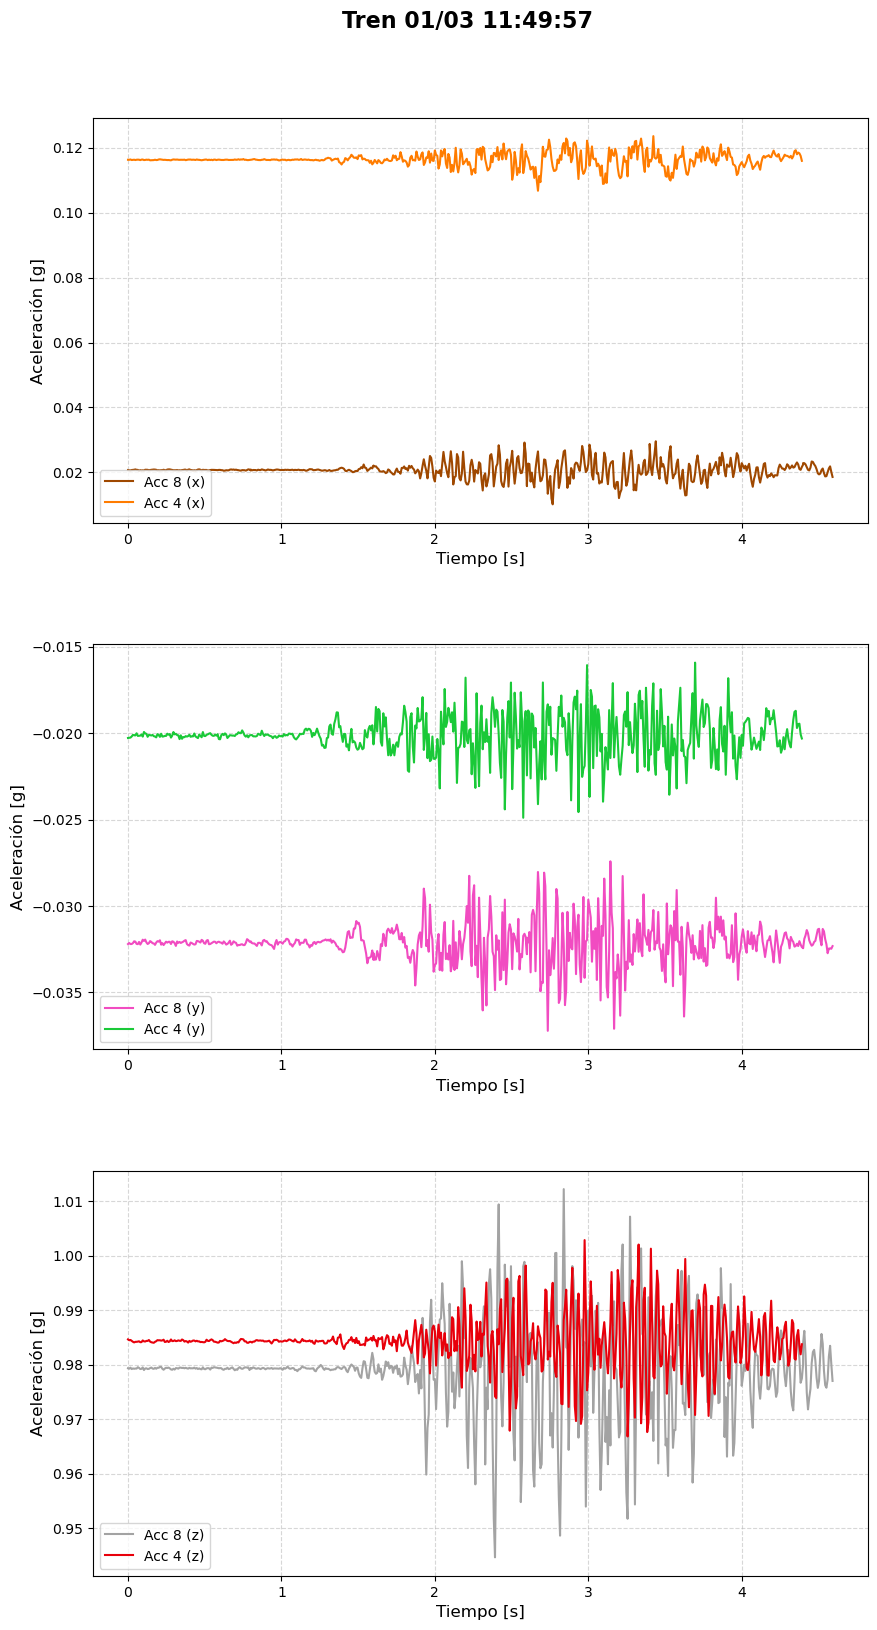

In [108]:
plot_train('Escritorio/SMART-BRIDGES/Guadiato/Guadiato-20250301_114958-20250301_115002.csv')